In [1]:
import sys
import time

import pandas as pd

import torch
import torch.nn as nn 
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import recall_score, accuracy_score, precision_score
from tqdm import tqdm

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

cuda:0
True
Tesla T4


### Set Hyperparameters

In [ ]:
batch_size    = 100
learning_rate = 0.01
num_epochs    = 10

n_dim = 64

### Load Datas

In [5]:
training_data = pd.read_csv("Dataset/monday_encoded.csv")
testing_data = pd.read_csv("Dataset/test.csv")

In [ ]:
# 인코딩 된 학습 데이터에서 인덱스 열 제거
training_data = training_data.drop(['Unnamed: 0'],axis=1)

# Encoding

### 데이터 전처리는 각 자리 수를 one-hot encoding


-  ip의 경우 각 자리 비교해서 one-hot encoding 하고 빈 부분은 0으로 padding해서 encoding 진행
-  ts와 te의 경우 날짜는 같으니 시간(시:분:초)만 가지고 one-hot encoding 진행
-  pr의 경우 세가지(0, 6, 17)로 구분되므로 3자리로 one-hot encoding 진행
- 이외의 경우 가장 큰수의 자리수에 맞춰서 padding 후 encoding 진행

In [ ]:
def encoding_time(input):
    input = input.split()[1] 
    input = input.split(':') 
    
    for i in range(len(input)):
        t = int(input[i])
        ten = torch.tensor(t // 10).reshape(1, 1)
        one = torch.tensor((t % 10) // 1).reshape(1, 1)
        ten = torch.zeros(1, 10).scatter_(1, ten, 1)
        one = torch.zeros(1, 10).scatter_(1, one, 1)
        concat = np.concatenate([ten, one], axis=0)
        
        if i == 0:
            result = np.concatenate([concat], axis=0)
        else:
            result = np.concatenate([before, concat], axis=0)
        before = result
        
    return result

def encoding_duration(input):
    t = int(input)

    if t == -1.0:
        num = torch.zeros(1, 10).scatter_(1, torch.tensor(0).reshape(1, 1), 1)
        result = np.concatenate([num, num, num, num, num, num, num, num, num], axis=0)
        return result
    else:
        first = torch.tensor((t // 100000000)).reshape(1, 1)
        second = torch.tensor((t % 100000000) // 10000000).reshape(1, 1)
        third = torch.tensor(((t % 100000000) % 10000000) // 1000000).reshape(1, 1)
        fourth = torch.tensor((((t % 100000000) % 10000000) % 1000000) // 100000).reshape(1, 1)
        fifth = torch.tensor(((((t % 100000000) % 10000000) % 1000000) % 100000) // 10000).reshape(1, 1)
        sixth = torch.tensor((((((t % 100000000) % 10000000) % 1000000) % 100000) % 10000) // 1000).reshape(1, 1)
        seventh = torch.tensor(((((((t % 100000000) % 10000000) % 1000000) % 100000) % 10000) % 1000) // 100).reshape(1, 1)
        eighth = torch.tensor((((((((t % 100000000) % 10000000) % 1000000) % 100000) % 10000) % 1000) % 100) // 10).reshape(1, 1)
        nineth = torch.tensor(((((((((t % 100000000) % 10000000) % 1000000) % 100000) % 10000) % 1000) % 100) % 10) // 1).reshape(1, 1)
        first = torch.zeros(1, 10).scatter_(1, first, 1)
        second = torch.zeros(1, 10).scatter_(1, second, 1)
        third = torch.zeros(1, 10).scatter_(1, third, 1)
        fourth = torch.zeros(1, 10).scatter_(1, fourth, 1)
        fifth = torch.zeros(1, 10).scatter_(1, fifth, 1)
        sixth = torch.zeros(1, 10).scatter_(1, sixth, 1)
        seventh = torch.zeros(1, 10).scatter_(1, seventh, 1)
        eighth = torch.zeros(1, 10).scatter_(1, eighth, 1)
        nineth = torch.zeros(1, 10).scatter_(1, nineth, 1)
        
        concat = np.concatenate([first, second, third, fourth, fifth, sixth, seventh, eighth, nineth], axis=0) 
        result = np.concatenate([concat], axis=0)
        
        return result

def encoding_ip(input):
    input = input.split('.')
    
    for i in range(len(input)):
        t = int(input[i])
        hund = torch.tensor((t // 100)).reshape(1, 1)
        ten = torch.tensor((t % 100) // 10).reshape(1, 1)
        one = torch.tensor(((t % 100) % 10) // 1).reshape(1, 1)
        hund = torch.zeros(1, 10).scatter_(1, hund, 1)
        ten = torch.zeros(1, 10).scatter_(1, ten, 1)
        one = torch.zeros(1, 10).scatter_(1, one, 1)
        concat = np.concatenate([hund, ten, one], axis=0)
        
        if i == 0:
            result = np.concatenate([concat], axis=0)
        else:
            result = np.concatenate([before, concat], axis=0)
        before = result
        
    return result

def encoding_port(input):
    t = int(input)
    tenthousand = torch.tensor(t // 10000).reshape(1, 1)
    thousand = torch.tensor((t % 10000) // 1000).reshape(1, 1)
    hund = torch.tensor(((t % 10000) % 1000) // 100).reshape(1, 1)
    ten = torch.tensor((((t % 10000) % 1000) % 100) // 10).reshape(1, 1)
    one = torch.tensor(((((t % 10000) % 1000) % 100) % 10) // 1).reshape(1, 1)
    tenthousand = torch.zeros(1, 10).scatter_(1, tenthousand, 1)
    thousand = torch.zeros(1, 10).scatter_(1, thousand, 1)
    hund = torch.zeros(1, 10).scatter_(1, hund, 1)
    ten = torch.zeros(1, 10).scatter_(1, ten, 1)
    one = torch.zeros(1, 10).scatter_(1, one, 1)
    
    concat = np.concatenate([tenthousand, thousand, hund, ten, one], axis=0)
    result = np.concatenate([concat], axis=0)
    
    return result

def encoding_protocol(input):
    t = int(input)
    if t == 6:
        type = torch.zeros(1, 3).scatter_(1, torch.tensor(0).reshape(1, 1), 1)
    elif t == 17:
        type = torch.zeros(1, 3).scatter_(1, torch.tensor(1).reshape(1, 1), 1)
    else:
        type = torch.zeros(1, 3).scatter_(1, torch.tensor(2).reshape(1, 1), 1)
        
    concat = np.concatenate([type], axis=0)
    result = np.concatenate([concat], axis=0)
    
    return result

def encoding_packets(input):
    t = int(input)
    hundredthousand = torch.tensor(t // 100000).reshape(1, 1)
    tenthousand = torch.tensor((t % 100000) // 10000).reshape(1, 1)
    thousand = torch.tensor(((t % 100000) % 10000) // 1000).reshape(1, 1)
    hund = torch.tensor((((t % 100000) % 10000) % 1000) // 100).reshape(1, 1)
    ten = torch.tensor(((((t % 100000) % 10000) % 1000) % 100) // 10).reshape(1, 1)
    one = torch.tensor((((((t % 100000) % 10000) % 1000) % 100) % 10) // 1).reshape(1, 1)
    hundredthousand = torch.zeros(1, 10).scatter_(1, hundredthousand, 1)
    tenthousand = torch.zeros(1, 10).scatter_(1, tenthousand, 1)
    thousand = torch.zeros(1, 10).scatter_(1, thousand, 1)
    hund = torch.zeros(1, 10).scatter_(1, hund, 1)
    ten = torch.zeros(1, 10).scatter_(1, ten, 1)
    one = torch.zeros(1, 10).scatter_(1, one, 1)
    
    concat = np.concatenate([hundredthousand, tenthousand, thousand, hund, ten, one], axis=0)
    result = np.concatenate([concat], axis=0)
    
    return result

def encoding_bytes(input):
    t = int(input)
    first = torch.tensor((t // 100000000)).reshape(1, 1)
    second = torch.tensor((t % 100000000) // 10000000).reshape(1, 1)
    third = torch.tensor(((t % 100000000) % 10000000) // 1000000).reshape(1, 1)
    fourth = torch.tensor((((t % 100000000) % 10000000) % 1000000) // 100000).reshape(1, 1)
    fifth = torch.tensor(((((t % 100000000) % 10000000) % 1000000) % 100000) // 10000).reshape(1, 1)
    sixth = torch.tensor((((((t % 100000000) % 10000000) % 1000000) % 100000) % 10000) // 1000).reshape(1, 1)
    seventh = torch.tensor(((((((t % 100000000) % 10000000) % 1000000) % 100000) % 10000) % 1000) // 100).reshape(1, 1)
    eighth = torch.tensor((((((((t % 100000000) % 10000000) % 1000000) % 100000) % 10000) % 1000) % 100) // 10).reshape(1, 1)
    nineth = torch.tensor(((((((((t % 100000000) % 10000000) % 1000000) % 100000) % 10000) % 1000) % 100) % 10) // 1).reshape(1, 1)
    first = torch.zeros(1, 10).scatter_(1, first, 1)
    second = torch.zeros(1, 10).scatter_(1, second, 1)
    third = torch.zeros(1, 10).scatter_(1, third, 1)
    fourth = torch.zeros(1, 10).scatter_(1, fourth, 1)
    fifth = torch.zeros(1, 10).scatter_(1, fifth, 1)
    sixth = torch.zeros(1, 10).scatter_(1, sixth, 1)
    seventh = torch.zeros(1, 10).scatter_(1, seventh, 1)
    eighth = torch.zeros(1, 10).scatter_(1, eighth, 1)
    nineth = torch.zeros(1, 10).scatter_(1, nineth, 1)
    
    concat = np.concatenate([first, second, third, fourth, fifth, sixth, seventh, eighth, nineth], axis=0)  
    result = np.concatenate([concat], axis=0)
    
    return result

def encoding_label(input):
    if input == 'BENIGN':
        type = torch.zeros(1, 2).scatter_(1, torch.tensor(0).reshape(1, 1), 1)
    else:
        type = torch.zeros(1, 2).scatter_(1, torch.tensor(1).reshape(1, 1), 1)
        
    concat = np.concatenate([type], axis=0)
    result = np.concatenate([concat], axis=0)
    
    return result


In [ ]:
functionList = [encoding_time, encoding_time, encoding_duration, encoding_ip, encoding_ip, encoding_port, encoding_port, encoding_protocol, encoding_packets, encoding_bytes, encoding_packets, encoding_bytes, encoding_label]

### Data Sampling

In [ ]:
training_data = training_data.sample(50000)
print(training_data.shape)

(50000, 855)


In [ ]:
training_data = torch.tensor(training_data.values)
training_data.dtype

torch.float64

In [ ]:
testing_data = testing_data.sample(n=10000)
print(testing_data.shape)

(10000, 13)


### Encoding Test Data

In [ ]:
for i in range(10000):
    print("Current: {} / {}".format(i, 10000))
    for j in range(testing_data.shape[1]):
        tmp = functionList[j](testing_data.iloc[i][j]).reshape(1, -1)
        if j == 0:
            result = np.concatenate([tmp], axis=1)
        else:
            result = np.concatenate([before, tmp], axis=1)
            
        before = result
     
    if i == 0:
        data_test = np.concatenate([result], axis=0)
    else:
        data_test = np.concatenate([before_total, result], axis=0)
        
    before_total = data_test

print(data_test.shape)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Current: 5001 / 10000
Current: 5002 / 10000
Current: 5003 / 10000
Current: 5004 / 10000
Current: 5005 / 10000
Current: 5006 / 10000
Current: 5007 / 10000
Current: 5008 / 10000
Current: 5009 / 10000
Current: 5010 / 10000
Current: 5011 / 10000
Current: 5012 / 10000
Current: 5013 / 10000
Current: 5014 / 10000
Current: 5015 / 10000
Current: 5016 / 10000
Current: 5017 / 10000
Current: 5018 / 10000
Current: 5019 / 10000
Current: 5020 / 10000
Current: 5021 / 10000
Current: 5022 / 10000
Current: 5023 / 10000
Current: 5024 / 10000
Current: 5025 / 10000
Current: 5026 / 10000
Current: 5027 / 10000
Current: 5028 / 10000
Current: 5029 / 10000
Current: 5030 / 10000
Current: 5031 / 10000
Current: 5032 / 10000
Current: 5033 / 10000
Current: 5034 / 10000
Current: 5035 / 10000
Current: 5036 / 10000
Current: 5037 / 10000
Current: 5038 / 10000
Current: 5039 / 10000
Current: 5040 / 10000
Current: 5041 / 10000
Current: 5042 / 10000
Current: 5043 / 10000
Current: 5044 / 10

# Model

In [ ]:
enc = nn.Sequential(
  nn.Linear(855, 256),
  nn.ReLU(),
  nn.Linear(256, 128),
  nn.ReLU(),
  nn.Linear(128, n_dim), 
)

if use_cuda:
  enc = enc.cuda()
print(enc)

Sequential(
  (0): Linear(in_features=855, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
)


In [ ]:
dec = nn.Sequential(
    nn.Linear(n_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 855),
    nn.Sigmoid()
)

if use_cuda:
  dec = dec.cuda()

print(dec)

Sequential(
  (0): Linear(in_features=64, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=855, bias=True)
  (5): Sigmoid()
)


In [ ]:
ae = nn.Sequential(
    enc,
    dec,
)

if use_cuda:
  ae = ae.cuda()

print(ae)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=855, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=855, bias=True)
    (5): Sigmoid()
  )
)


In [ ]:
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_normal_(m.weight)  # xavier

ae.apply(init_weights)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=855, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=855, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
data_train = training_data
data_test = torch.tensor(data_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
if use_cuda:
  data_train = data_train.to(device)
  y_pred = ae(data_train.float()).cuda()
else:
  y_pred = ae(data_train.float())

y_pred = y_pred.reshape(data_train.shape[0],855)
print('input  shape:', data_train.shape)
print('output shape:', y_pred.shape)

input  shape: torch.Size([50000, 855])
output shape: torch.Size([50000, 855])


In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary

if use_cuda:
  summary(ae.cuda(), (1, 855))  
else:
  summary(ae, (1, 855))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         219,136
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 64]           8,256
            Linear-6               [-1, 1, 128]           8,320
              ReLU-7               [-1, 1, 128]               0
            Linear-8               [-1, 1, 256]          33,024
              ReLU-9               [-1, 1, 256]               0
           Linear-10               [-1, 1, 855]         219,735
          Sigmoid-11               [-1, 1, 855]               0
Total params: 521,367
Trainable params: 521,367
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
# test_data를 배치 단위로 나누기

l1 = []
l2 = []

num1 = data_train.shape[0]-100
num2 = data_train.shape[0]

for i in range(data_train.shape[0]//100):
  l1.insert(0,num1) 
  num1 -= 100

  l2.insert(0,num2)
  num2 -= 100

In [ ]:
def fit(images, epochs, batch_size):
  for epoch in range(epochs):
    now = time.time()
    avg_loss = 0
    total_batch = images.shape[0] // batch_size
    
    for f,s in zip(l1,l2):
      batch_images = images[f:s]

      X = batch_images.view(-1, 855)
      if use_cuda:
        X = batch_images.view(-1, 855).to(device)

      # forward 단계
      # 1. input data를 모델에 통과시킵니다.
      # 2. loss를 계산합니다.
      Y_prediction = ae(X)
      loss = criterion(Y_prediction, X)

      # bacward 단계
      # 1. backprop 단계를 실행하기 전에 변화도를 0으로 만듭니다.
      # 2. 모델의 매개변수에 대한 손실의 변화도를 계산합니다.
      # 3. step 함수를 호출하면 매개변수가 갱신됩니다.
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      avg_loss += loss / total_batch

    print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
          .format(epoch + 1, avg_loss.data, time.time()-now))
      
  print("Learning Finished!")

# Training

In [ ]:
fit(data_train.float(), num_epochs, batch_size)

[Epoch:    1] 	 loss = 544.2072 	 time = 2.9019
[Epoch:    2] 	 loss = 544.0753 	 time = 2.5351
[Epoch:    3] 	 loss = 544.0753 	 time = 2.9423
[Epoch:    4] 	 loss = 544.0753 	 time = 2.6413
[Epoch:    5] 	 loss = 544.0753 	 time = 1.3083
[Epoch:    6] 	 loss = 544.0753 	 time = 1.3091
[Epoch:    7] 	 loss = 544.0753 	 time = 1.3555
[Epoch:    8] 	 loss = 544.0753 	 time = 1.3014
[Epoch:    9] 	 loss = 544.0753 	 time = 1.3184
[Epoch:   10] 	 loss = 544.0753 	 time = 1.3172
Learning Finished!


### Visualize Input & Output

In [ ]:
if use_cuda:
  data_train = data_train.to(device)
  z = enc(data_train.float()).cuda()
  y_pred = dec(z).cuda()
else:
  z = enc(data_train.float())
  y_pred = dec(z)

print(np.shape(data_train))
print(np.shape(y_pred))

torch.Size([50000, 855])
torch.Size([50000, 855])


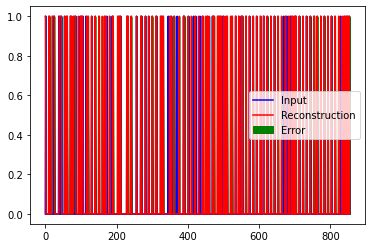

In [ ]:
encoded_imgs = z.detach().cpu().numpy()
decoded_imgs = y_pred.detach().cpu().numpy()

plt.plot(training_data.detach().cpu().numpy()[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(855), decoded_imgs[0], training_data.detach().cpu().numpy()[0], color='g')
plt.legend(labels=["Input", "Reconstruction", "Error"])

In [ ]:
if use_cuda:
  data_test = data_test.to(device)
  z = enc(data_test.float()).cuda()
  y_pred = dec(z).cuda()
else:
  z = enc(data_test.float())
  y_pred = dec(z)

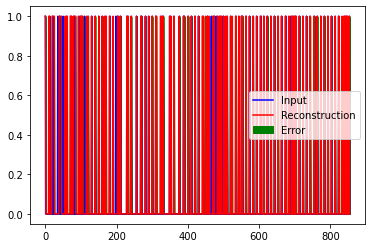

In [ ]:
encoded_imgs = z.detach().cpu().numpy()
decoded_imgs = y_pred.detach().cpu().numpy()

plt.plot(data_test.detach().cpu().numpy()[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(855), decoded_imgs[0], data_test.detach().cpu().numpy()[0], color='g')
plt.legend(labels=["Input", "Reconstruction", "Error"])

# Set Threshold

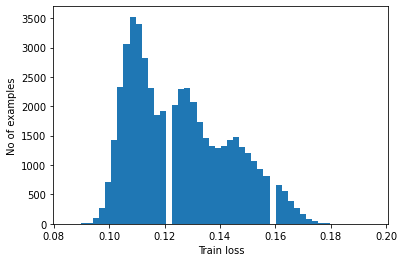

In [ ]:
l_func = nn.L1Loss()

l = []

for i in range(data_train.shape[0]):
    reconstruct = ae(data_train[i].float())
    loss = l_func(data_train[i], reconstruct)
    l.append(loss)

l = torch.tensor(l)

plt.hist(l.detach().cpu(), bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
# Calculate threshold on training data

threshold = np.mean(l.numpy()) + np.std(l.numpy())
print("Threshold: ", threshold)

Threshold:  0.14353059141881158


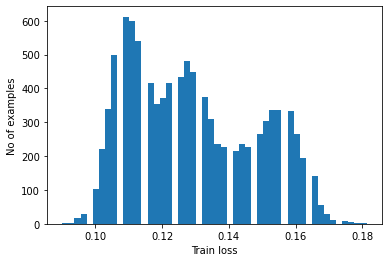

In [ ]:
l = []

for i in range(data_test.shape[0]):
    reconstruct = ae(data_test[i].cuda())
    loss = l_func(data_test[i].cuda(), reconstruct)
    l.append(loss)

l = torch.tensor(l)

plt.hist(l.detach().cpu(), bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
preds = l > threshold
print(preds)

tensor([False, False, False,  ..., False, False, False])


# Results

In [ ]:
# Accuracy 계산을 위한 Label 변환

label_train = []
label_test = []

for i in data_train:
  if(i[-1] == 0):
    label_train.append(0)
  else:
    label_train.append(1)

for i in data_test:
  if(i[-1] == 0):
    label_test.append(0)
  else:
    label_test.append(1)


print(data_train.shape[0] == len(label_train))
print(data_test.shape[0] == len(label_test))

True
True


In [ ]:
# thresholds on test

print("Accuracy = {}".format(accuracy_score(label_test, preds)))
print("Precision = {}".format(precision_score(label_test, preds)))
print("Recall = {}".format(recall_score(label_test, preds)))

Accuracy = 0.7292
Precision = 0.4547437295528899
Recall = 0.5087433916226108
